cluster dei rifugi: 
- caratteristiche territoriali (es. altitudine, gruppi rocciosi/idrici, ..) 
- vicinanza (distanza) tra rifugi
- cluster ranking rifugi → per individuare gruppi di performance e vedere se e come cambiano (quali rifugi cambiano classi)

In [22]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from rasterio.sample import sample_gen
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.simplefilter("ignore")


# Territorial Clustering
Cluster based on topographic characteristics: 
- altitude, slope, aspect
- connection to trail network, roads, cableways
- water potential ?
- corpi idrici sotterranei (gruppo geologico) ?

In [7]:
# Load DEM raster
dem_path = "../data/terrain/tinitaly_dem50m.tif"
dem = rasterio.open(dem_path)

# Load slope raster
slope_path = "../data/terrain/tinitaly_slope50m.tif"
slope_raster = rasterio.open(slope_path)

# Load huts GeoDataFrame
huts = gpd.read_file("../data/huts/huts_points.geojson")
huts.to_crs(dem.crs, inplace=True)

In [8]:
## Extract elevation & slope
hut_coords = [(geom.x, geom.y) for geom in huts.geometry]

elevation = [val[0] for val in sample_gen(dem, hut_coords)]
slope = [val[0] for val in sample_gen(slope_raster, hut_coords)]

huts['elevation'] = elevation
huts['slope'] = slope

In [9]:
# Accessibility: already extracted in mcdm_analysis.ipynb
huts_criteria = gpd.read_parquet('../data/alternatives_unfiltered.parquet')
huts_criteria.to_crs(dem.crs, inplace=True)
huts_criteria.columns

Index(['standard_name', 'nome_strut', 'categoria_CAISAT', 'categoria_PAT',
       'posti_letto', 'quota', 'geometry', 'acquedotto', 'sorgente',
       'superficiale', 'cisterna_m3', 'CR_WA_01', 'CR_WA_02', 'cogeneratore',
       'generatore', 'potenza_gruppoel_kw', 'riserva', 'fotovoltaico',
       'potenza_fotov_kw', 'accumulo_fotov_V', 'accumulo_fotov_ah',
       'idroelettrico', 'potenza_idro_kw', 'rete_elettrica', 'gas_gpl',
       'solare_termico', 'riscaldamento', 'CR_EN_01', 'CR_EN_02', 'CR_EN_03',
       'CR_EN_04', 'supply_aerialway', 'supply_helicopter', 'supply_road',
       'CR_SU_01', 'CR_SU_02', 'lift_ids_within_500m', 'lift_ids_within_2300m',
       'car_access', 'arrival_trails', 'CR_AC_01', 'CR_AC_02', 'CR_AC_03',
       'CR_HO_01', 'CR_HO_02'],
      dtype='object')

In [10]:
selected_cols = ['standard_name', 'supply_aerialway', 'supply_helicopter', 'supply_road', 'lift_ids_within_500m',
       'lift_ids_within_2300m', 'car_access', 'arrival_trails']
huts = huts.merge(huts_criteria[selected_cols], on='standard_name', how='left')

In [11]:
# Extract data for lifts and number of trails
if 'num_trails' not in huts.columns:
    huts['num_trails'] = None
    
for idx, row in huts.iterrows():
    huts.at[idx, 'lift_500m'] = row['lift_ids_within_500m'] is not None
    huts.at[idx, 'lift_2300m'] = row['lift_ids_within_2300m'] is not None

    if row['arrival_trails'] is not None and len(row['arrival_trails']) > 0:
        huts.at[idx, 'num_trails'] = len(row['arrival_trails'])

huts.drop(columns=['lift_ids_within_500m', 'lift_ids_within_2300m'], inplace=True)
huts.head(5)

,standard_name,nome_strut,categoria_CAISAT,categoria_PAT,posti_letto,quota,geometry,elevation,slope,supply_aerialway,supply_helicopter,supply_road,car_access,arrival_trails,num_trails,lift_500m,lift_2300m
0,alpepozzavlancia,"ALPE POZZA ""VINCENZO LANCIA""",C,Alp,50,1802,POINT (666584.351 5077095.370),1802.240967,6.714721,False,False,True,False,"[E101, E102, E105, E131, E120, E132]",6,False,False
1,altissimodchiesa,"ALTISSIMO ""DAMIANO CHIESA""",C,Alp,35,2060,POINT (646874.183 5074717.942),2058.592041,8.659462,False,False,True,False,"[O622, O633, O601]",3,False,False
2,antermoia,ANTERMOIA,D,Alp,61,2496,POINT (704489.000 5150499.000),2497.357910,6.731922,True,False,True,False,"[E584, E580, E583]",3,False,False
3,bindesipprati,"BINDESI ""PINO PRATI""",A,Escurs,0,618,POINT (666672.806 5100323.693),594.101807,47.511280,False,False,True,True,[E412],1,False,False
4,boccaditratnpernici,"BOCCA DI TRAT ""NINO PERNICI""",C,Alp,28,1601,POINT (637133.000 5087416.000),1615.531982,29.171103,False,False,True,False,"[O413, O402, O420, O403, O445]",5,False,False


## Feature clustering: K-means
I use k-means to cluster huts based on the features above, which regard topographic characteristics (elevation and slope) and accessibility (for supplying and visitors).

In [25]:
# Select relevant features for clustering
features = ['elevation', 'slope', 'supply_aerialway', 'supply_helicopter', 
            'supply_road', 'car_access', 'num_trails', 'lift_500m', 'lift_2300m']
X = huts[features]

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42) 
huts['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

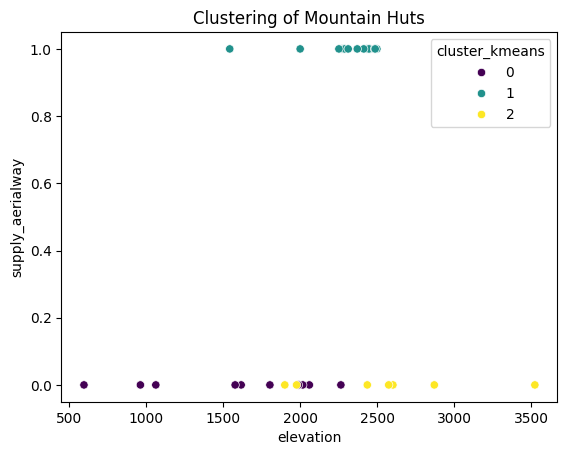

In [14]:
# Visualize the clusters in 2d (2 features)
sns.scatterplot(data=huts, x='elevation', y='supply_aerialway', hue='cluster_kmeans', palette='viridis')
plt.title("Clustering of Mountain Huts")
plt.show()


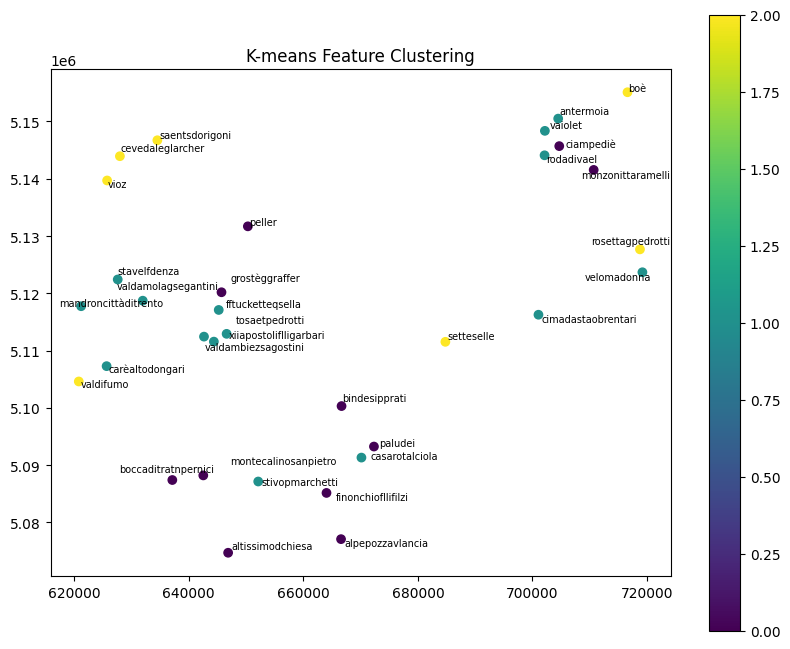

In [26]:
## Plot the clustered points (coordinates)
fig, ax = plt.subplots(figsize=(10, 8))
huts.plot(column='cluster_kmeans', cmap='viridis', legend=True, ax=ax)

texts = []
for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    texts.append(ax.text(x, y, name, fontsize=7))
adjust_text(texts, ax=ax)

plt.title("K-means Feature Clustering")
plt.show()

## Proximity clustering: DBSCAN
Unlike k-means, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) doesn't require the number of clusters to be specified beforehand and can identify outliers (noise). It is based on the concept of **core points**, which represent the centers of clusters. A point is considered a core point if it has at least `min_samples` points (including itself) within a distance of `eps`. Clusters are formed by grouping together all points that are connected (density-reachable, either direclty or via other connected points) to at least one core point; points that are not density-reachable from any other point are classified as noise or outliers.

DBSCAN proves as an efficient algorithm for **spatial clustering** to identify groups of huts that are close-by based on their coordinated and elevation. 

In [16]:
# Extract coordinates as np array
coords = np.array(list(huts.geometry.apply(lambda geom: (geom.x, geom.y))))
# combine other features
features = np.hstack([coords, huts[['elevation']].values])

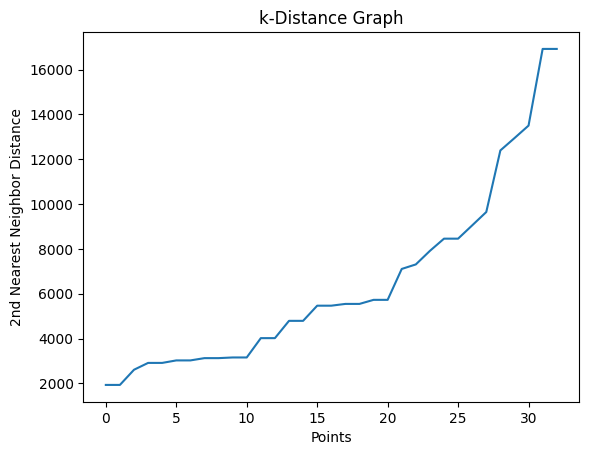

In [20]:
# Tune eps parameter with a k-distance graph: the distance from a point to its k-th nearest neighbor, look for elbow
# Fit Nearest Neighbors
neigh = NearestNeighbors(n_neighbors=2)  # min_samples-1
neigh.fit(coords)
distances, _ = neigh.kneighbors(coords)

# Sort and plot distances
distances = np.sort(distances[:, -1])  # Last column is the k-th neighbor distance
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("2nd Nearest Neighbor Distance")
plt.title("k-Distance Graph")
plt.show()


In [23]:
# DBSCAN parameters
eps = 5000  # Distance threshold in meters (adjust as needed)
min_samples = 2  # Minimum number of huts to form a cluster

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
huts['cluster_dbscan'] = dbscan.fit_predict(features)

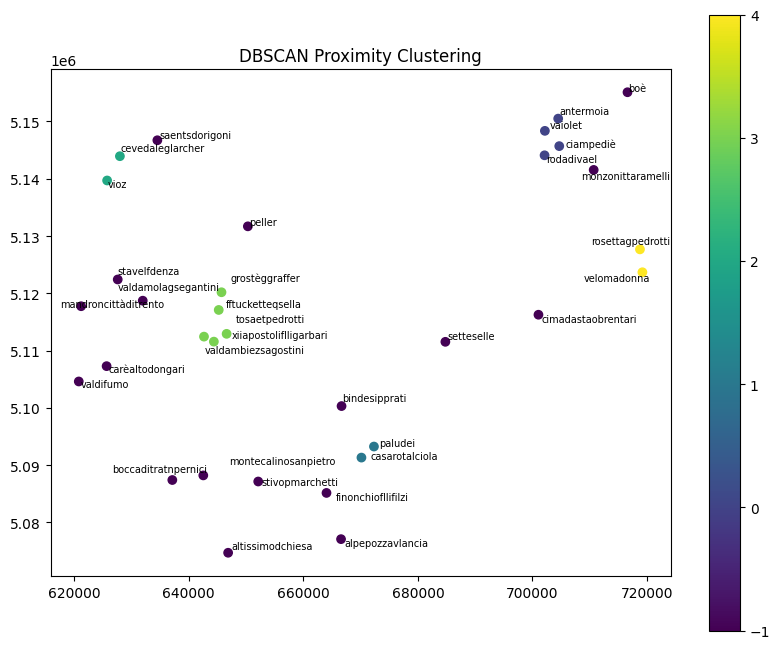

In [24]:
## Plot the clustered points
fig, ax = plt.subplots(figsize=(10, 8))
huts.plot(column='cluster_dbscan', cmap='viridis', legend=True, ax=ax)

texts = []
for x, y, name in zip(huts.geometry.x, huts.geometry.y, huts['standard_name']):
    texts.append(ax.text(x, y, name, fontsize=7))
adjust_text(texts, ax=ax)

plt.title("DBSCAN Proximity Clustering")
plt.show()


The clusters obtained reflect 2 things:
- the feature clusters produces by K-means (k=3) appear to be divided in: (1) huts with a supply aerialway (blue); (2) huts without a supply aerialway, at lower altitudes/more accessible; (3) huts without a supply aerialway, at higher altitudes/more remote. This classification should be further explored, also trying to change the number of k clusters.
- the proximity clusters were produced with eps=5000 (meters) and min_samples=2 to identify possible 'support networks' of close-by huts. I allow small clusters of 2 huts since they are sparse. The results show 5 groups of close huts (considering position and elevation), this should be further investigated by plotting a DEM or slope map underneath. 